In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import bigrams,trigrams
from nltk.tokenize import word_tokenize,sent_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import re
from heapq import nlargest
from spellchecker import SpellChecker
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [2]:
SEED = 13
np.random.seed(SEED)

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('all-corpora')  # use in case you are unsure what to download so download all

[nltk_data] Downloading package wordnet to /home/deshwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/deshwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/deshwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stopword = set(stopwords.words('english'))
stopword.update(['amp','cc','rt','@handle']) # rt = retweet

stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

# Input

In [5]:
df = pd.read_csv('train_tweets.txt', sep="\t", header=None,names=['id','tweet'])

In [6]:
df.head()

,id,tweet
0,8746,@handle Let's try and catch up live next week!
1,8746,Going to watch Grey's on the big screen - Thur...
2,8746,@handle My pleasure Patrick....hope you are well!
3,8746,@handle Hi there! Been traveling a lot and lot...
4,8746,RT @handle Looking to Drink Clean & Go Green? ...


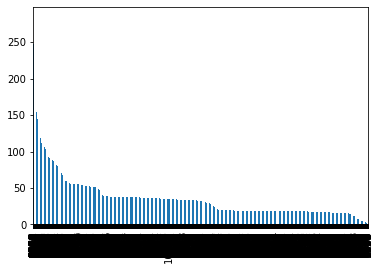

In [7]:
df['id'].value_counts().plot(kind='bar')

In [8]:
df['id'].value_counts().describe()

count    9293.000000
mean       35.316367
std        28.056033
min         1.000000
25%        18.000000
50%        32.000000
75%        38.000000
max       284.000000
Name: id, dtype: float64

9293 different authors with an average of 35 posts per person where a single person has written 284 maximum posts and 1 at minimum

In [9]:
df['id'].value_counts().sort_values(ascending=False)

4185    284
319     273
5519    273
4267    265
4562    264
       ... 
3987      1
7019      1
6682      1
691       1
3142      1
Name: id, Length: 9293, dtype: int64

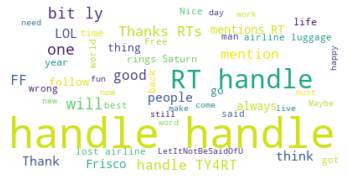

In [10]:
text= ''.join(df[df['id']==4185]['tweet'].values.tolist()) # get tweets of user who has tweeted most

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Turn this cell to code to run but it'll take some time
text = ''.join(df['tweet'].values.tolist())
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Helpers

In [11]:
def remove_stopwords(text):
    return ' '.join([word.lower() for word in text.split(' ') if word.lower() not in stopword and len(word)>2])

In [12]:
def get_vocab(data):
    vocab = {}
    for tweet in tqdm(data):
        for word in tweet.split(' '):
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [13]:
def text_cleaner(text):
    
    # text = re.sub(r'^https?:\/\/.*[\r\n]*', '-URL-', text, flags=re.MULTILINE) # sub URL
    text = re.sub(r'http\S+', ' ', text) 
    text = re.sub(r'www\S+', ' ', text) 
    
    text = re.sub(r'\d',' ',text) # remove any number
    
    # text = re.sub('@handle',' ',text)
    text = re.sub(r'@\w+', '', text)
    
    text = re.sub(r'[:]',' ',text) # special characters
    text = re.sub(r'[-]',' ',text)
    text = re.sub(r'[!]',' ',text)
    text = re.sub(r'[_]',' ',text)
    text = re.sub('[?]',' ',text)
    text = re.sub('[.]',' ',text)
    text = re.sub('[+]',' ',text)
    text = re.sub('[=]',' ',text)
    
    # text = re.sub(r'([\W_])\1+',' ',text) # multiple repeating special characters
    text = re.sub(r'(?<=\s)[\W\d](?=(\s|$))', ' ', text)
    text = re.sub(r'(?<=\w)\W+(?=(\s|$))', ' ', text)
    text = re.sub(r'(\W)\1+(?=\w)', r'\1', text)
    
    text = re.sub('\n',' ',text)
    text = re.sub('\s\s+',' ',text) # multiple space
    text = text.lstrip()
    text = text.rstrip()
    return text   

In [14]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
"could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
"hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
"I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
"i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", 
"it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", 
"let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
"mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
"needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
"oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
"she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
 "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
 "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
 "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
 "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
 "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
 "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
 "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
 "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
 "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
 "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
 "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
 "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
 "y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
 "you'll've": "you will have", "you're": "you are", "you've": "you have", "ya'll": "you all" ,"let's":'let us'}

def remove_contraction(text):
    for word in text.split(' '):
        if word.lower() in contraction_dict:
            text = text.replace(word, contraction_dict[word.lower()])  
    return text

# Pre Processing

In [15]:
df['tweet'] = df['tweet'].apply(lambda text: remove_contraction(text)) # remove contractions
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text)) # remove stopwords
df['tweet'] = df['tweet'].apply(lambda text: text_cleaner(text)) #  clean text

df['tweet'] = df['tweet'].apply(lambda text: ' '.join([lemma.lemmatize(word) for word in text.split(' ')]))
# lemmatize

In [16]:
df['tweet_len'] = df['tweet'].apply(lambda x: len(x.split(' ')))

rows_to_drop = df[(df['tweet_len']<2) & (~df['tweet'].str.contains('#'))].index
df.drop(rows_to_drop,inplace=True)

# Drop rows which do not have any hashtag and have less than 2 elements

In [17]:
X_train,X_test,y_train,y_test = train_test_split(df['tweet'],df['id'], test_size=0.25,random_state=SEED,)

In [18]:
vocab = get_vocab(X_train)

100%|██████████| 236852/236852 [00:00<00:00, 258347.09it/s]


In [19]:
# sorted_vocab = nlargest(len(vocab),vocab,vocab.get)

In [20]:
tfv = TfidfVectorizer(min_df=2,  max_features=None, max_df=0.75,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(2, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [ ]:
tfv.fit(list(X_train))
X_train =  tfv.transform(X_train) 
X_test = tfv.transform(X_test)

In [ ]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)